**Word2Vec implementation in JAX**

This tutorial provides a complete step-by-step implementation of the Word2Vec model developed by [Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf%C3%AC%E2%80%94%20%C3%AC%E2%80%9E%C5%93) using [JAX](https://github.com/google/jax).

Some resources on Word2Vec:
- https://web.stanford.edu/~jurafsky/slp3/6.pdf
- https://arxiv.org/pdf/1411.2738.pdf
- https://jalammar.github.io/illustrated-word2vec/

Some resources on JAX:
- https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb#scrollTo=6lTI6I4lWdh5
- https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

## **0. Setup**

In [7]:
import sys
import pandas as pd
import numpy as np
from scipy import spatial

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import value_and_grad
import jax.nn as nn
from jax.random import PRNGKey as Key
from collections import Counter
import time
from jax.experimental import optimizers
import nltk
import string
import re
import math
import pickle
import random

import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import spatial
from annoy import AnnoyIndex
from IPython import display

import preprocessing_class as pc

## **1. Data Generation: The Skipgram model**

Word2Vec relies on a very simple, but powerful, intuition about text data; the order of the words contains valuable information. Instead of transforming all text into a bag-of-words representation, Word2Vec uses the order of the words to define a prediction task. Concretely, this task can be formulated in two different ways:

1. **Continous Bag of Words (CBOW):** Predict a word given the words in it's context. We want to model $Pr(w_t | w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2})$
2. **Skip-gram:** Model the context given a center word. We want to model $Pr(w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2} | w_t)$

The figure below ([Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf%C3%AC%E2%80%94%20%C3%AC%E2%80%9E%C5%93)) clearly shows these 2 different prediction tasks. In this tutorial we will focus on the **skip-gram model**.

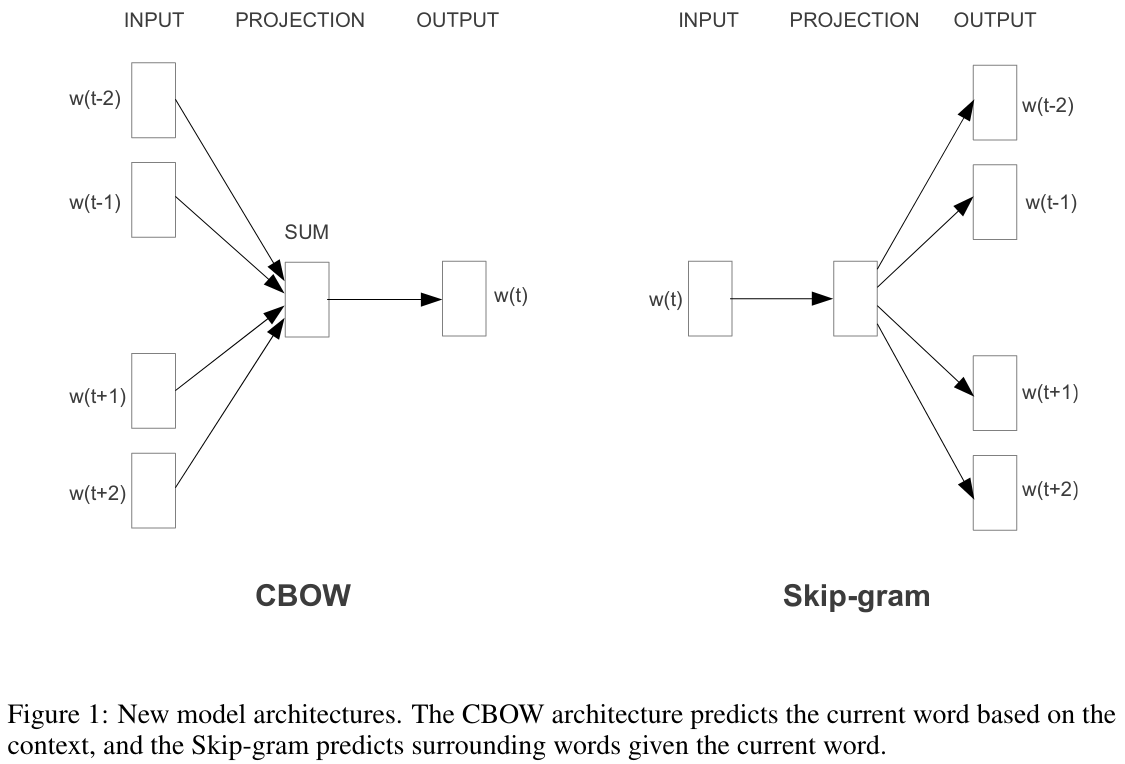

In [8]:
display.Image("images/cbow_skipgram.png", width=1200, height=800)

In [9]:
def skipgram_examples(corpus, vocab_dict, window=2):
    """ Function to identify center and context words in the provided corpus.
        Examples are only generated for words that are in a position in which 
        sufficient context words are available (window*2).
    
    Args:
        corpus (list): containing each document of the corpus represented
        as a list of tokens
        
        vocab_dict (dict): mapping words to their index representation
        
        window (int): window*2 will be the total number of words considered
        as context; (window) words before and (window) words after the
        selected center word
        
    Returns:
        jax array of indexes representing each center word in the corpus
        jax array of jax arrays representing the indexes of context words
    """

    # lists to store the results
    centers = []
    contexts = []
    
    # iterate over al documents in the corpus
    for doc in corpus:

        center = window
        while center < (len(doc)-window):
            # save the current center word
            centers.append(vocab_dict[doc[center]])
            # create a list to store the context of the current center
            context_words = []
            # search for context
            for i in range(0, (window*2)+1):
                if (center-window+i) != center:
                    context_words.append(vocab_dict[doc[center-window+i]])

            # append all the context words identified
            contexts.append(context_words)
            # update center
            center += 1
                   
    return jnp.array(centers), jnp.array(contexts)

### **1.1. Load data and preprocess text**

We will now load some real data in order to understand the data structure that we are generating for the skip-gram model. We see that our data consists of paragraphs from the Inflation Reports produced by the Bank of England. The data starts on 1998 and ends in 2015. Reports are produced fours times a year in the months of February, May, August and November.

In [10]:
data = pd.read_csv("ir_data_final.txt", sep="\t")
data["year"] = pd.to_datetime(data['ir_date'], format='%Y%m')
data['yearmonth'] = data["year"].dt.strftime("%Y%m")
print(data.shape)
data.head(10)

(15023, 9)


,ir_date,paragraph,section,sub_section,sub_sub_section,sub_sub_sub_section,sub_sub_sub_sub_section,year,yearmonth
0,199802,It is almost six years since output reached it...,0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
1,199802,Monetary policy is currently being pulled in o...,0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
2,199802,"On the other hand, the delayed demand effect o...",0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
3,199802,"The scale of the slowdown depends, in part, on...",0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
4,199802,"Net trade is weakening, but domestic demand gr...",0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
5,199802,The combination of sharply weakening net trade...,0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
6,199802,The MPC’s probability distribution for the fou...,0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
7,199802,The MPC’s projection of the twelve-month RPIX ...,0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
8,199802,"Overall, the balance of risks to inflation in ...",0.0,NaN,NaN,NaN,NaN,1998-02-01,199802
9,199802,"Against the background of this projection, the...",0.0,NaN,NaN,NaN,NaN,1998-02-01,199802


In [11]:
# check how often these reports are produced
grouped = data.groupby("yearmonth", as_index=False).size()
print(grouped.head(5))
print(grouped.tail(5))

  yearmonth  size
0    199802   177
1    199805   161
2    199808   195
3    199811   176
4    199902   191
   yearmonth  size
65    201405   235
66    201408   229
67    201411   220
68    201502   214
69    201505   214


In [12]:
# define pattern for tokenization
pattern = r'''(?x)      # set flag to allow verbose regexps
        (?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
        | \$?\d+(?:\.\d+)?\$?%? # currency and percentages, e.g. $12.40, 82%
        | \w+-(?=$|\s) # words with hyphens at the end (does not handle "stuff-.")
        | \w+(?:[-|&]\w+)*   # words with optional internal hyphens or &
        | \.\.\.             # ellipsis
        | [][.,;"'?():-_`]   # these are separate tokens; includes ], [
    '''

In [13]:
# define a list of expressions that we would like to preserve as a single token
replace_dict = {}
replace_dict["interest rate"] = "interest-rate"
replace_dict["interest rates"] = "interest-rate"
replace_dict["monetary policy"] = "monetary-policy"

In [14]:
# define punctuation symbols to remove
punctuation = string.punctuation
punctuation = punctuation.replace("&", "")
punctuation = punctuation.replace("-", "")
punctuation

'!"#$%\'()*+,./:;<=>?@[\\]^_`{|}~'

In [15]:
def apply_preprocessing(data, replace_dict, punctuation):
    """ Function to apply the steps from the preprocessing class in the correct
        order to generate a term frequency matrix and the appropriate dictionaries
    """
    
    prep = pc.RawDocs(data["paragraph"], stopwords="short", lower_case=True, contraction_split=True, tokenization_pattern=pattern)
    prep.phrase_replace(replace_dict=replace_dict, items='tokens', case_sensitive_replacing=False)
    prep.token_clean(length=2, punctuation=punctuation, numbers=True)
    prep.dt_matrix_create(items='tokens', min_df=10, score_type='df')
    
    # get the vocabulary and the appropriate dictionaries to map from indices to words
    word2idx = prep.vocabulary["tokens"]
    idx2word = {i:word for word,i in word2idx.items()}
    vocab = list(word2idx.keys())
    
    return prep, word2idx, idx2word, vocab

In [16]:
# use preprocessing class
prep, word2idx, idx2word, vocab = apply_preprocessing(data, replace_dict, punctuation)

In [17]:
# inspect a random tokenized document and compare to its original form
i = np.random.randint(0, len(prep.tokens))
print(data.loc[i, "paragraph"])
print("\n ------------------------------- \n")
print(prep.tokens[i])

PNFCs raised £3.7 billion in sterling loans in the fourth quarter, after a small net repayment in the third quarter. There was also a sharp increase in money raised through bond issuance.  PNFCs’ total external finance was higher than in the third quarter, even though the total figure was depressed by repayments of foreign-currency debt (see Chart 1.16).  The level of external finance raised in Q4 remained below the average between 1999 and 2002.  But the increase in bond issuance, coupled with the improvement in PNFCs’ financial position, could be consistent with a modest strengthening in business investment in the coming months.  

 ------------------------------- 

['pnfcs', 'raised', 'billion', 'sterling', 'loans', 'the', 'fourth', 'quarter', 'after', 'small', 'net', 'repayment', 'the', 'third', 'quarter', 'there', 'was', 'also', 'sharp', 'increase', 'money', 'raised', 'through', 'bond', 'issuance', 'pnfcs', 'total', 'external', 'finance', 'was', 'higher', 'than', 'the', 'third', '

In [18]:
# check that our bigrams of interest are in the vocabulary
print(word2idx["monetary-policy"], word2idx["interest-rate"])

1991 1666


### **1.2. Skip-gram examples**

Given that we have choosen the skip-gram model, our examples from the corpus will be pairs of composed of a center word and it's surrounding K words. We will use the parameter *window* of the function to define how many words we want to consider at each side of the center word. A value of 5 for this argument, for example, means that each one of our examples will be constitued by a center word and the 5 words before it with the 5 words after it.

In [19]:
# generate the examples setting a window size of 4
window_size = 4
centers, contexts = skipgram_examples(prep.tokens, word2idx, window_size)
print(centers.shape, contexts.shape)

(961683,) (961683, 8)


In [20]:
# let's look at the first example generated
print(f"Tokens of first document in corpus:\n {prep.tokens[0]}\n")
print(f"First center word choosen: {idx2word[centers[0].item()]}\n")
context_words = [idx2word[i.item()] for i in contexts[0]]
print(f"Associated context words: {context_words}")

Tokens of first document in corpus:
 ['almost', 'six', 'years', 'since', 'output', 'reached', 'its', 'trough', 'the', 'last', 'recession', 'since', 'then', 'output', 'has', 'risen', 'average', 'rate', 'year', 'and', 'inflation', 'has', 'fallen', 'from', 'almost', 'below', 'year', 'the', 'combination', 'above-trend', 'growth', 'and', 'falling', 'inflation', 'unsustainable', 'and', 'has', 'probably', 'already', 'come', 'end', 'this', 'juncture', 'with', 'output', 'growth', 'likely', 'fall', 'sharply', 'monetary-policy', 'more', 'finely', 'balanced', 'than', 'any', 'point', 'since', 'the', 'inflation', 'target', 'was', 'introduced', 'the', 'central', 'issue', 'whether', 'the', 'existing', 'policy', 'stance', 'will', 'slow', 'the', 'economy', 'sufficiently', 'quickly', 'prevent', 'further', 'upward', 'pressure', 'earnings', 'growth', 'and', 'retail', 'price', 'inflation']

First center word choosen: output

Associated context words: ['almost', 'six', 'years', 'since', 'reached', 'its', 'tr

### **1.3. Negative sampling**

We have already produced the examples that appeared in the corpus (*positive examples*). But we are still missing a piece from the problem; we not only want the probability of the context words to be high, given the center word, but **we would also like this probability to be low for words that are NOT part of the context**. However, in practice, this is a tremendously expensive term to compute; it requires operating over all words that are not part of the context (which by definition are going to be almost all). Negative sampling is a solution to this problem. Instead of operating over all words that are not in the context, we operate over a random subsample of them. This strategy is at the core of Word2Vec and has shown good results.

In order to simplify the code, we will obtain these negative samples from a uniform distribution over the words in the vocabulary that are not part of the context in consideration. However, the authors of Word2Vec claim that the best results are obtained when these samples are obtained from a weighted unigram frequency distribution with weigth $\alpha = 0.75$.

$$
P_\alpha(w) = \frac{count(w)^{\alpha}}{\sum_{w'} count(w')^{\alpha}}
$$

In [21]:
def gen_neg_samples(centers_idxs, contexts_idxs, vocab_idxs, num_ns): 
    """ Function to generate negative samples. The number of negative 
        samples produced for each center word will be equal 
        to: neg_samples*window_size*2
    
    Args:
        center_idx (array): containing the index of the center word
        contexts_idx (array): containing the indexes for the context words
        vocab_idxs (array): indices of all the vocabulary tokens
        num_ns (int): number of desired negatives samples PER (CENTER_i, CONTEXT_j) PAIR
        
    Returns
        - A jnp array with the negative samples for each center word
    """
    
    window_size = np.int(contexts_idxs.shape[1]/2)
    neg_idxs = [random.sample(set(vocab_idxs) - set(context) - set([center.item()]), window_size*num_ns*2) for context, center in zip(contexts_idxs, centers_idxs)]

                
    return jnp.array(neg_idxs)

In [22]:
# num_ns defines the number of negative samples per positve pair
num_ns = 10
neg_samples = gen_neg_samples(centers, contexts, list(idx2word.keys()), num_ns)
print(neg_samples.shape)

(961683, 80)


In [23]:
# explore a random negative sample
i = np.random.randint(0, neg_samples.shape[0])
print(f"Center word index: {centers[i]}\n")
print(f"Associated context words indices: {contexts[i]}\n")
print(f"Negative samples (none of these indices should appear in the real context):\n {neg_samples[i]}\n")
intersection = set(contexts[i]).intersection(set(neg_samples[i]))
print(f"Intersection of indices: {intersection}")

Center word index: 2274

Associated context words indices: [2565 1584 1618 3372 2214 1804 2758  973]

Negative samples (none of these indices should appear in the real context):
 [3163  394 3367  588  680  519 3059 2303 2402   13  597 1691 1901 3213
  986 2787 3299 2515  878 1943 1358  871   35 3131 2942    5 2603  648
  183  684 1857 1643 2210 3081 1340 3326 3104 1516  373 1776 2976 2204
 1085 2738 3177 1206 1767  117 2352 3393 2584 2912  249 1431  896 1161
  992 2095  261 1020 3261 2325 2216 3404  340 3014 2690   38 3490 3011
 3161 1491  786 2327 2564 3106  989  733 1169   93]

Intersection of indices: set()


## **2. Model**

Now that we have the data and an overarching idea of our objective we can formalize this. The description and figure below [Jurafski & Martin (2020) Chapter 6](https://web.stanford.edu/~jurafsky/slp3/6.pdf) provide a great explanation and formalization on the aim of the Word2Vec learning algorithm.

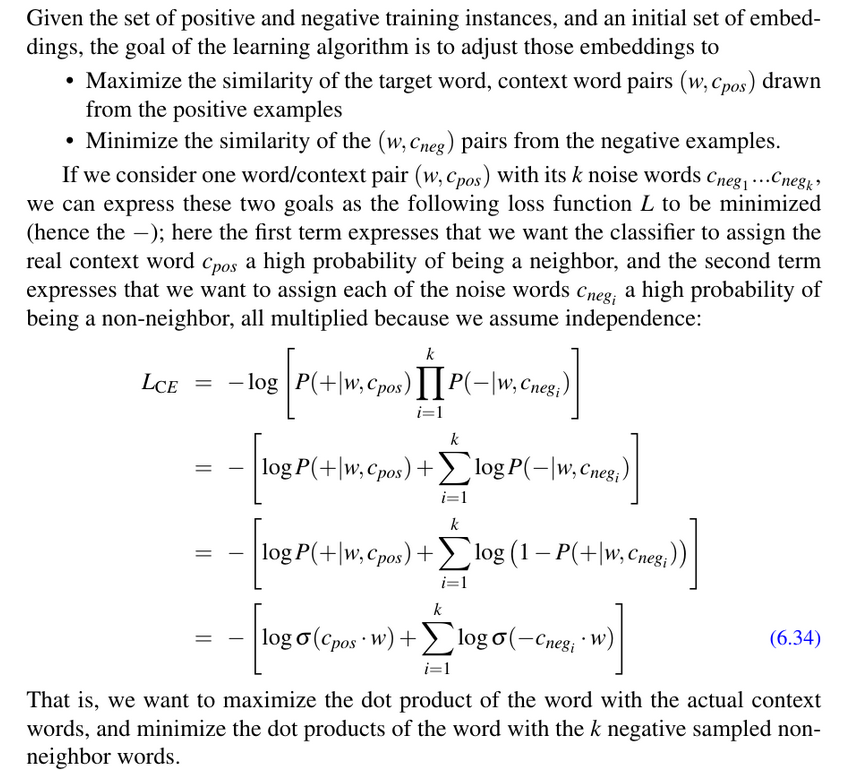

In [24]:
display.Image("images/model1.png", width=800, height=800)

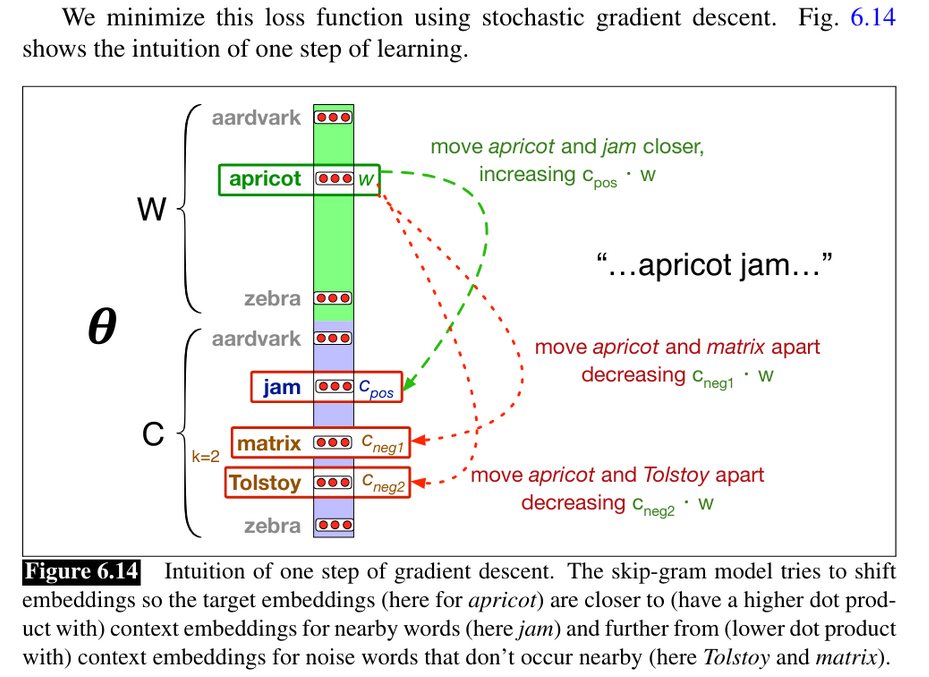

In [25]:
display.Image("images/model2.png", width=800, height=800)

### **2.1. Parameters and Predictions**

In [32]:
def init_params(vocab_size, emb_size, mean, std, seed):
    """ Function to generate random initial parameter matrices
    
    Args:
        vocab_size (int)
        emb_size (int)
        mean (float): of  normal distribution
        std (float): of normal distribution
        seed (int): to initialize NumPy generator
    
    Returns:
        list with two matrices randomly generated with the specified dimensions
    """
    
     
    # initialize the generator
    generator = np.random.default_rng(seed)
    
    W = jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size)))
    C = jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size)))
    
    return [W, C]

In [33]:
params = init_params(len(vocab), emb_size=100, mean=0, std=1, seed=92)
print(params[0].shape, params[1].shape)

(3573, 100) (3573, 100)


In [34]:
@jit
def predict_probs(params, center_idx, contexts_idx):
    """ Estimate the probability of the context words given a center word
    
    Args:
        params (list): containing the parameters of the model
        center_idx (int): index of the center word
        contexts_idx (list): containing the indexes of the context words
    
    Returns:
        jax array with one probability for each context word
    """
    
    # unpack the wegihts matrices: Word embeddings and Context embeddings
    W, C = params[0], params[1]
    
    # get the W-embedding of the center word
    W_center = jnp.take(W, center_idx, axis=0)
    
    # get the C-embedding for the context words
    C_contexts = jnp.take(C, contexts_idx, axis=0)
    
    # similarity score: dot product of word embedding of center word and 
    # context embeddings of context words
    similarities = W_center@C_contexts.T
    
    # finally, in order to transform this similarity into a probability we use
    # the sigmoid function
        
    return jax.nn.sigmoid(similarities)

In [35]:
# let's see the estimated probabilities for a random example
i = np.random.randint(0, centers.shape[0])
preds = predict_probs(params, centers[i], contexts[i])
print(preds.shape)
print(preds)

(8,)
[1.6075821e-01 5.4325392e-03 9.9648774e-01 4.3908465e-01 9.9913615e-01
 1.2711428e-04 1.0000000e+00 3.6324473e-13]


We can see that we have 8 different predicted probabilities (one for each word in the context). At the moment these probabilities are completely random because we have initialized the parameters randomly. However, we will train the parameters of the model (the embeddings matrices) in order for these probabilities to increase.

In [36]:
# we can use this same function with the negative samples
i = np.random.randint(0, centers.shape[0])
preds_neg = predict_probs(params, centers[i], neg_samples[i])
print(preds_neg.shape)
print(preds_neg)

(80,)
[9.99829412e-01 9.99999881e-01 4.93378907e-01 4.29530472e-01
 5.34372889e-02 7.00894418e-08 3.37184826e-03 8.16896558e-01
 9.99862671e-01 9.73179638e-01 7.99473696e-07 9.99618769e-01
 9.98239517e-01 4.94454755e-03 8.62049311e-03 9.99999523e-01
 1.31775010e-07 9.99997377e-01 1.23342963e-08 7.33995795e-01
 3.76081305e-10 1.17816024e-04 9.99527216e-01 9.99945521e-01
 9.99896884e-01 1.87211007e-01 1.00000000e+00 1.97406393e-02
 7.60079503e-01 1.00000000e+00 4.77221608e-01 4.82995674e-04
 1.94922308e-07 9.29919422e-01 1.10607594e-04 9.93685424e-01
 9.99308825e-01 2.20631175e-02 1.23811606e-03 5.28999045e-03
 9.89047229e-01 9.99425650e-01 2.22090026e-03 8.57670903e-01
 9.88525212e-01 9.90162492e-01 9.98572469e-01 2.50681012e-04
 3.34494910e-03 6.51660741e-07 3.70486727e-04 9.99999762e-01
 9.99999523e-01 9.46112692e-01 9.99999523e-01 9.76181090e-01
 8.53852153e-01 5.88476087e-06 9.99864340e-01 1.19523995e-03
 6.89526722e-02 9.98075247e-01 8.34873378e-01 9.99999046e-01
 9.99998212e-01 7.

Now we see that we generated 80 probabilities (10 probabilities for each one of the 8 real context words). After training the parameters we want these probabilities to be low! 

### **2.2. Loss function**

In [37]:
@jit
def loss_per_example(params, center_idx, contexts_idx, ns_idx, noise=0.000001):
    """ calculate the loss for a center word and it's positive and
        negative examples
    
    Args:
        params (list): containing the parameters of the model
        center_idx (int): index of the context word
        contexts_idx (list): containing the indexes of the contexts words
        ns_idx (jax array): containing the indexes of the negative samples
        noise (int): small quantity to avoid passing zero to the logarithm

    Returns:
        loss for a single example
    """
            
    #----------------------------
    # Loss from positive samples
    #----------------------------
    
    # get the scores for the real context
    preds_pos = predict_probs(params, center_idx, contexts_idx)
    
    # loss for the positive (real) context words
    loss_pos = jnp.sum(jnp.log(preds_pos + noise))
    
    #----------------------------
    # Loss from negative samples
    #----------------------------
    
    # get the scores for all the negative samples
    preds_neg = 1 - predict_probs(params, center_idx, ns_idx)
    
    # loss for the negative samples
    loss_neg = jnp.sum(jnp.log(preds_neg + noise))
    
    return -(loss_pos + loss_neg)

In [38]:
# create a vectorized version of the loss using the vmap function from JAX
# the option "in_axes" indicates over which parameters to iterate
batched_loss = jit(vmap(loss_per_example, in_axes=(None, 0, 0, 0, None)))

In [39]:
@jit
def complete_loss(params, all_center_idx, all_contexts_idx, all_ns_idx, noise):
    """ function to calculate the loss for a batch of data by adding the
        individual losses for each example
    
    Args:
        params (list): containing the parameters of the model
        all_center_idx (list): containing all indexes of center words
        all_contexts_idx (list): containing the indexes for the context words
        all_ns_idx (list): containing all negative samples

    Returns:
        average loss for all examples (float)
    """
        
    # get all losses from the examples
    losses = batched_loss(params, all_center_idx, all_contexts_idx, all_ns_idx, noise)
    
    return jnp.sum(losses)/all_center_idx.shape[0]

In [40]:
# use JAX to create a vesion of the loss function that can handle gradients
# the option "argnums" indicates where the parameters of the model are.
# finally use JIT to speed up computations... All JAX magic in one place

grad_loss = jit(value_and_grad(complete_loss, argnums=0))

In [41]:
@jit
def update(params, step, all_center_idx, all_contexts_idx, all_ns_idx, noise, opt_state):
    """ compute the gradient for a batch of data and update parameters
    """
    
    # calculate the gradients and the value of the loss function
    loss_value, grads = grad_loss(params, all_center_idx, all_contexts_idx, all_ns_idx, noise)
    
    # update the parameters with a gradient descent algorithm
    opt_state = opt_update(step, grads, opt_state)

    return loss_value, get_params(opt_state), opt_state 

### **2.3. Training**

In [ ]:
# create some lists to log data
loss_epoch = []

# define vocabulary and embedding size
vocab_size = len(vocab)
emb_size = 100

# training parameters
noise = 1e-8
step_size = 0.001
num_epochs = 20
batch_size = 32

# randomly initialize the two weights matrices
params_seed = 92
params_mean = 0
params_std = 1

params = init_params(vocab_size, emb_size, params_mean, params_std, params_seed)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

# keep track of how many times we are updating the parameters
num_updates = 0

num_batches = math.floor(centers.shape[0]/batch_size)
print(f"Number of batches to process {num_batches} in {num_epochs} epochs")

# train through the epochs
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # IMPORTANT: SHUFFLE EXAMPLES IN EVERY EPOCH!    
    indexes = jnp.array(list(range(0, centers.shape[0])))
    shuffled_idx = jax.random.permutation(Key(epoch), indexes)
    centers = jnp.take(centers, shuffled_idx, axis=0)
    contexts = jnp.take(contexts, shuffled_idx, axis=0)
    neg_samples = jnp.take(neg_samples, shuffled_idx, axis=0)
    
    # split data into batches
    init_index = 0
    end_index = batch_size
    
    loss_epoch_list = []
    for batch in range(num_batches+1):
        
        # get the data from the current batch
        batch_idx = jnp.array(range(init_index, end_index))
        batch_centers = jnp.take(centers, batch_idx, axis=0)
        batch_contexts = jnp.take(contexts, batch_idx, axis=0)
        batch_ns = jnp.take(neg_samples, batch_idx, axis=0)
        
        # calculate gradients and update parameters for each batch
        loss_batch, params, opt_state = update(params, num_updates, batch_centers, 
                                                    batch_contexts, batch_ns, noise, opt_state)
        loss_epoch_list.append(loss_batch)
        num_updates += 1
        
        # update indexes
        init_index = end_index
        # if we are in the last batch...
        if batch == num_batches-1:
            end_index = centers.shape[0]
        else:
            end_index += batch_size
                
    epoch_time = time.time() - start_time
    loss_epoch.append(sum(loss_epoch_list))
    
    if epoch%10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Loss value: {}".format(sum(loss_epoch_list)))
    
plt.plot(list(range(num_epochs)), loss_epoch)
plt.show()

Number of batches to process 30052 in 20 epochs


## **4. Nearest neighbors analysis**

Now that we have a numeric representation of all words in the vocabulary, it is possible to calculate distances between these representations.

In [54]:
def build_indexer(vectors, num_trees=10):
    """ we will use a version of approximate nearest neighbors
        (ANNOY: https://github.com/spotify/annoy) to build an indexer
        of the embeddings matrix
    """
    
    # angular = cosine
    indexer = AnnoyIndex(vectors.shape[1], 'angular')
    for i, vec in enumerate(vectors):
        # add word embedding to indexer
        indexer.add_item(i, vec)
        
    # build trees for searching
    indexer.build(num_trees)
    
    return indexer

In [39]:
# create an indexer for our estimated word embeddings (more trees means higher query precision)
indexer = build_indexer(params[0], num_trees=10000)

In [57]:
def find_nn(word, word2idx, idx2word, annoy_indexer, n=5):
    """ function to find the nearest neighbors of a given word
    """
    word_index = word2idx[word]
    nearest_indexes =  annoy_indexer.get_nns_by_item(word_index, n+1)
    nearest_words = [idx2word[i] for i in nearest_indexes[1:]]
    
    return nearest_words

In [41]:
word = "growth"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of growth in the corpus:

['gdp', 'four-quarter', 'slowing', 'slowed', 'productivity', 'annual', 'subdued', 'output', 'slowdown', 'earnings', 'below-trend', 'robust', 'consumption', 'pickup', 'trend', 'real', 'stronger', 'slow', 'momentum', 'contrast']


In [42]:
word = "economy"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of economy in the corpus:

['world', 'global', 'capacity', 'potential', 'spare', 'supply', 'activity', 'gradually', 'demand', 'economic', 'whole', 'slack', 'emerging', 'inflationary', 'margin', 'recovery', 'productivity', 'degree', 'expansion', 'rebalancing']


In [43]:
word = "uncertainty"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of uncertainty in the corpus:

['considerable', 'about', 'surrounding', 'heightened', 'iraq', 'concerns', 'conflict', 'timing', 'uncertain', 'inherent', 'future', 'risk', 'views', 'regarding', 'magnitude', 'wide', 'relate', 'confidence', 'precise', 'sides']


In [44]:
word = "interest-rate"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of interest-rate in the corpus:

['official', 'short-term', 'rates', 'implied', 'path', 'yields', 'long-term', 'repo', 'differentials', 'expectations', 'market', 'forward', 'risk-free', 'basis', 'nominal', 'rate', 'real', 'fomc', 'monetary-policy', 'follows']


In [45]:
word = "inflation"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of inflation in the corpus:

['cpi', 'rpix', 'target', 'price', 'expectations', 'rpi', 'medium', 'upside', 'food', 'outturns', 'above-target', 'medium-term', 'near', 'ahead', 'short-term', 'wage', 'beyond', 'drops', 'term', 'twelve-month']


In [46]:
word = "recession"
N = 20
print(f"{N} nearest neighbors of {word} in the corpus:\n")
print(find_nn(word, word2idx, idx2word, indexer, N))

20 nearest neighbors of recession in the corpus:

['crisis', 'downturn', 'much', 'businesses', 'during', 'recessions', 'unemployment', 'start', 'hourly', 'capacity', 'loss', 'full-time', 'beginning', 'mid-', 'period', 'trend', 'participation', 'since', 'companies', 'margin']


## **5. Visualization**

TODO: Generate a more meaningful visualization. Include more words or at least a large number of words related to monetary policy.

In [48]:
pca = PCA(n_components=2, random_state=92)

In [49]:
low_dim_emb = pca.fit_transform(params[0])
print(low_dim_emb.shape)

(3573, 2)


In [50]:
words_plot = ["slowdown", "recession", "crisis", "boom",  "growth", "recovery"]
words_idxs = [word2idx[w] for w in words_plot]
low_dim_words = [low_dim_emb[idx] for idx in words_idxs]
low_dim_words = np.array(low_dim_words)
low_dim_words.shape

(6, 2)

In [51]:
df_plot = pd.DataFrame({"x": low_dim_words[:,0], "y": low_dim_words[:,1], "word": words_plot})
df_plot

,x,y,word
0,-0.269677,1.337530,slowdown
1,-0.173867,0.477177,recession
2,-0.798840,0.444579,crisis
3,0.599359,0.810433,boom
4,-0.012676,1.221398,growth
5,-1.017833,1.364621,recovery


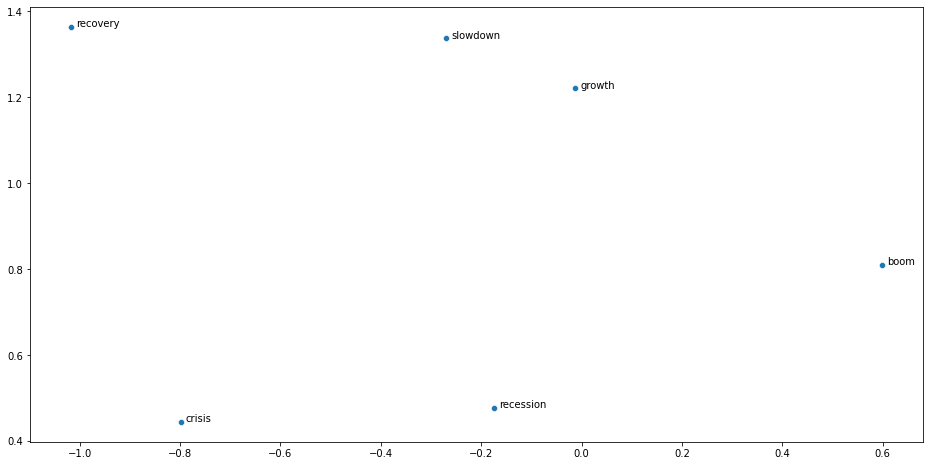

In [52]:
plt.figure(figsize=(16,8))
ax = sns.scatterplot(x=low_dim_words[:,0], y=low_dim_words[:,1])

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))

label_point(df_plot["x"], df_plot["y"], df_plot["word"], plt.gca()) 

## **6. Business Cycle**

In [36]:
# clean data from previous estimation
del centers
del contexts
del neg_samples

In [37]:
# load OECD data on recessions for the UK
# A value of 1 is a recessionary period, while a value of 0 is an expansionary period. 
recession_ind = pd.read_csv("UK_recession.csv")
recession_ind.head(10)

,DATE,GBRRECDM
0,1998-01-01,0.0
1,1998-01-02,0.0
2,1998-01-03,0.0
3,1998-01-04,0.0
4,1998-01-05,0.0
5,1998-01-06,0.0
6,1998-01-07,0.0
7,1998-01-08,0.0
8,1998-01-09,0.0
9,1998-01-10,0.0


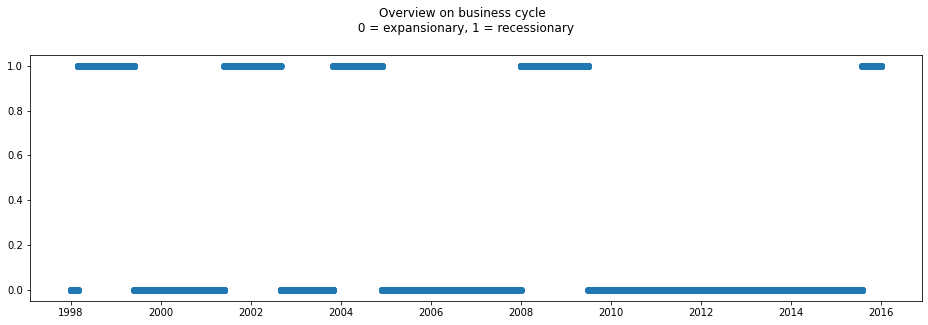

In [38]:
# transform date into datetime format
recession_ind["DATE"] = pd.to_datetime(recession_ind["DATE"])

# create plot to visualize cylces
fig,ax = plt.subplots(figsize=(13,6))
fig.suptitle('Overview on business cycle \n 0 = expansionary, 1 = recessionary')
ax.scatter(recession_ind["DATE"], recession_ind["GBRRECDM"])
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.3, right=None, top=0.87, wspace=0.3, hspace=0.6)
plt.show()

Using this information, we are going two select to approximately equally sized periods of time that are in different parts of the business cycle. We will call them: 
- "decreasing" (recessionary): March, 2008 - July, 2009
- "increasing" (expansionary): March, 2006 - July, 2007

In [40]:
# check the status of some days
recession_ind.loc[recession_ind["DATE"] == "2009-06-18"]

,DATE,GBRRECDM
4186,2009-06-18,1.0


In [41]:
df_dec = data.loc[(data["yearmonth"] >= "200803") & (data["yearmonth"] < "200907")]
df_dec.shape

(1038, 9)

In [42]:
df_inc = data.loc[(data["yearmonth"] >= "200603") & (data["yearmonth"] < "200707")]
df_inc.shape

(1055, 9)

In [44]:
# preprocess reports from the DECREASING part of the business cycle
prep_dec, word2idx_dec, idx2word_dec, vocab_dec = apply_preprocessing(df_dec, replace_dict, punctuation)
print(f"Number of words in the vocabulary: {len(vocab_dec)}")

Number of words in the vocabulary: 913


In [45]:
# preprocess reports from the INCREASING part of the business cycle
prep_inc, word2idx_inc, idx2word_inc, vocab_inc = apply_preprocessing(df_inc, replace_dict, punctuation)
print(f"Number of words in the vocabulary: {len(vocab_inc)}")

Number of words in the vocabulary: 881


In [46]:
# generate the examples setting a window size of 4
window_size = 4

In [47]:
# generate skip-gram examples
centers_dec, contexts_dec = skipgram_examples(prep_dec.tokens, word2idx_dec, window_size)
print("Examples for decreasing reports:")
print(centers_dec.shape, contexts_dec.shape)

centers_inc, contexts_inc = skipgram_examples(prep_inc.tokens, word2idx_inc, window_size)
print("\nExamples for increasing reports:")
print(centers_inc.shape, contexts_inc.shape)

Examples for decreasing reports:
(58001,) (58001, 8)

Examples for increasing reports:
(50632,) (50632, 8)


In [48]:
num_ns = 10

In [49]:
neg_samples_dec = gen_neg_samples(centers_dec, contexts_dec, list(idx2word_dec.keys()), num_ns)
print(neg_samples_dec.shape)

neg_samples_inc = gen_neg_samples(centers_inc, contexts_inc, list(idx2word_inc.keys()), num_ns)
print(neg_samples_inc.shape)

(58001, 80)
(50632, 80)


In [59]:
# define training parameters
noise = 1e-8
step_size = 0.001
num_epochs = 50
batch_size = 64

emb_size = 100

Number of batches to process 906 in 50 epochs
Epoch 0 in 4.74 sec
Loss value: 27638.923828125
Epoch 10 in 2.67 sec
Loss value: 15693.3330078125
Epoch 20 in 2.73 sec
Loss value: 15035.0478515625
Epoch 30 in 2.52 sec
Loss value: 14755.9287109375
Epoch 40 in 2.83 sec
Loss value: 14599.2431640625


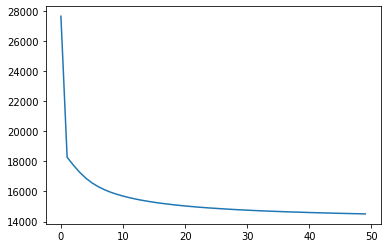

In [60]:
#----------------------------------------
# Model training for DECREASING periods
#----------------------------------------

# create some lists to log data
loss_epoch = []

vocab_size_dec = len(vocab_dec)

# randomly initialize the two weights matrices
params_seed = 92
params_mean = 0
params_std = 0.1

params_dec = init_params(vocab_size_dec, emb_size, params_mean, params_std, params_seed)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_dec)

# keep track of how many times we are updating the parameters
num_updates = 0

num_batches = math.floor(centers_dec.shape[0]/batch_size)
print(f"Number of batches to process {num_batches} in {num_epochs} epochs")

# train through the epochs
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # IMPORTANT: SHUFFLE EXAMPLES IN EVERY EPOCH!    
    indexes = jnp.array(list(range(0, centers_dec.shape[0])))
    shuffled_idx = jax.random.permutation(Key(epoch), indexes)
    centers_dec = jnp.take(centers_dec, shuffled_idx, axis=0)
    contexts_dec = jnp.take(contexts_dec, shuffled_idx, axis=0)
    neg_samples_dec = jnp.take(neg_samples_dec, shuffled_idx, axis=0)
    
    # split data into batches
    init_index = 0
    end_index = batch_size
    
    loss_epoch_list = []
    for batch in range(num_batches+1):
        
        # get the data from the current batch
        batch_idx = jnp.array(range(init_index, end_index))
        batch_centers = jnp.take(centers_dec, batch_idx, axis=0)
        batch_contexts = jnp.take(contexts_dec, batch_idx, axis=0)
        batch_ns = jnp.take(neg_samples_dec, batch_idx, axis=0)
        
        # calculate gradients and update parameters for each batch
        loss_batch, params_dec, opt_state = update(params_dec, num_updates, batch_centers, 
                                                    batch_contexts, batch_ns, noise, opt_state)
        loss_epoch_list.append(loss_batch)
        num_updates += 1
        
        # update indexes
        init_index = end_index
        # if we are in the last batch...
        if batch == num_batches-1:
            end_index = centers_dec.shape[0]
        else:
            end_index += batch_size
                
    epoch_time = time.time() - start_time
    loss_epoch.append(sum(loss_epoch_list))
    
    if epoch%10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Loss value: {}".format(sum(loss_epoch_list)))

    
plt.plot(list(range(num_epochs)), loss_epoch)
plt.show()

Number of batches to process 906 in 50 epochs
Epoch 0 in 2.91 sec
Loss value: 25531.69140625
Epoch 10 in 3.26 sec
Loss value: 13921.7392578125
Epoch 20 in 3.12 sec
Loss value: 13440.0927734375
Epoch 30 in 2.74 sec
Loss value: 13047.986328125
Epoch 40 in 2.47 sec
Loss value: 12727.9638671875


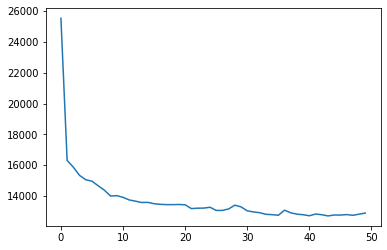

In [61]:
#----------------------------------------
# Model training for INCREASING periods
#----------------------------------------

# create some lists to log data
loss_epoch = []

vocab_size_inc = len(vocab_inc)

# randomly initialize the two weights matrices
params_seed = 92
params_mean = 0
params_std = 0.1

params_inc = init_params(vocab_size_inc, emb_size, params_mean, params_std, params_seed)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_inc)

# keep track of how many times we are updating the parameters
num_updates = 0

num_batches = math.floor(centers_dec.shape[0]/batch_size)
print(f"Number of batches to process {num_batches} in {num_epochs} epochs")

# train through the epochs
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # IMPORTANT: SHUFFLE EXAMPLES IN EVERY EPOCH!    
    indexes = jnp.array(list(range(0, centers_inc.shape[0])))
    shuffled_idx = jax.random.permutation(Key(epoch), indexes)
    centers_inc = jnp.take(centers_inc, shuffled_idx, axis=0)
    contexts_inc = jnp.take(contexts_inc, shuffled_idx, axis=0)
    neg_samples_inc = jnp.take(neg_samples_inc, shuffled_idx, axis=0)
    
    # split data into batches
    init_index = 0
    end_index = batch_size
    
    loss_epoch_list = []
    for batch in range(num_batches+1):
        
        # get the data from the current batch
        batch_idx = jnp.array(range(init_index, end_index))
        
        # if there is no more data to process
        if len(batch_idx) == 0:
            continue
            
        batch_centers = jnp.take(centers_inc, batch_idx, axis=0)
        batch_contexts = jnp.take(contexts_inc, batch_idx, axis=0)
        batch_ns = jnp.take(neg_samples_inc, batch_idx, axis=0)
        
        # calculate gradients and update parameters for each batch
        loss_batch, params_inc, opt_state = update(params_inc, num_updates, batch_centers, 
                                                    batch_contexts, batch_ns, noise, opt_state)
        loss_epoch_list.append(loss_batch)
        num_updates += 1
        
        # update indexes
        init_index = end_index
        # if we are in the last batch...
        if batch == num_batches-1:
            end_index = centers_inc.shape[0]
        else:
            end_index += batch_size
                
    epoch_time = time.time() - start_time
    loss_epoch.append(sum(loss_epoch_list))
    
    if epoch%10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Loss value: {}".format(sum(loss_epoch_list)))
    
plt.plot(list(range(num_epochs)), loss_epoch)
plt.show()

In [62]:
# create an indexer for our estimated word embeddings
# This will allow us to easily find nearest neighbors
indexer_dec = build_indexer(params_dec[0], num_trees=10000)
indexer_inc = build_indexer(params_inc[0], num_trees=10000)

In [63]:
word = "economy"
N = 20
print(f"{N} nearest neighbors of {word} in the DECREASING corpus:\n")
print(find_nn(word, word2idx_dec, idx2word_dec, indexer_dec, N))
print("-----------------------------------------------------------------")
print(f"{N} nearest neighbors of {word} in the INCREASING corpus:\n")
print(find_nn(word, word2idx_inc, idx2word_inc, indexer_inc, N))

20 nearest neighbors of economy in the DECREASING corpus:

['depends', 'assessing', 'speed', 'but', 'supply', 'remainder', 'depend', 'the', 'slack', 'likely', 'section', 'recession', 'potential', 'degree', 'persistent', 'ease', 'chain', 'slows', 'key', 'components']
-----------------------------------------------------------------
20 nearest neighbors of economy in the INCREASING corpus:

['spare', 'particular', 'degree', 'remains', 'judge', 'judges', 'pace', 'capacity', 'world', 'information', 'suggest', 'signs', 'assumed', 'resources', 'uncertainty', 'directly', 'broad', 'indicate', 'still', 'rapid']


In [64]:
word = "inflation"
N = 20
print(f"{N} nearest neighbors of {word} in the DECREASING corpus:\n")
print(find_nn(word, word2idx_dec, idx2word_dec, indexer_dec, N))
print("-----------------------------------------------------------------")
print(f"{N} nearest neighbors of {word} in the INCREASING corpus:\n")
print(find_nn(word, word2idx_inc, idx2word_inc, indexer_inc, N))

20 nearest neighbors of inflation in the DECREASING corpus:

['cpi', 'expectations', 'target', 'above-target', 'assumptions', 'upside', 'outturns', 'judged', 'upwards', 'shown', 'risks', 'import', 'medium', 'judge', 'horizon', 'whether', 'medium-term', 'but', 'near-term', 'elevated']
-----------------------------------------------------------------
20 nearest neighbors of inflation in the INCREASING corpus:

['cpi', 'target', 'expectations', 'price', 'necessary', 'import', 'outcomes', 'monetary-policy', 'non-energy', 'what', 'central', 'moved', 'charts', 'projection', 'short-term', 'meet', 'influenced', 'likely', 'imported', 'probabilities']


In [65]:
pairs = [("economy", "risk"), ("inflation", "risk"), ("economy", "increase"), ("economy", "slowdown")]

for pair in pairs:
    cos_dec = 1 - spatial.distance.cosine(params_dec[0][word2idx_dec[pair[0]]], params_dec[0][word2idx_dec[pair[1]]])
    print(f"Cosine similarity between {pair[0]} and {pair[1]} in the DECREASING corpus: {np.round(cos_dec, 2)}\n")
    cos_inc = 1 - spatial.distance.cosine(params_inc[0][word2idx_inc[pair[0]]], params_inc[0][word2idx_inc[pair[1]]])
    print(f"Cosine similarity between {pair[0]} and {pair[1]} in the INCREASING corpus: {np.round(cos_inc, 2)}\n")
    print("--------------------------------------------------------")

Cosine similarity between economy and risk in the DECREASING corpus: 0.2

Cosine similarity between economy and risk in the INCREASING corpus: 0.12

--------------------------------------------------------
Cosine similarity between inflation and risk in the DECREASING corpus: 0.3

Cosine similarity between inflation and risk in the INCREASING corpus: 0.19

--------------------------------------------------------
Cosine similarity between economy and increase in the DECREASING corpus: 0.12

Cosine similarity between economy and increase in the INCREASING corpus: 0.11

--------------------------------------------------------
Cosine similarity between economy and slowdown in the DECREASING corpus: 0.25

Cosine similarity between economy and slowdown in the INCREASING corpus: 0.2

--------------------------------------------------------


## **7. Grouped Embeddings**

Instead of learning embeddings in a completely separate way, we could formulate the problem differently.

There are two main features that distinguish this model from a traditional word2vec approach.

1. By using the same context embeddings for all groups, the model generates group-specific embeddings that are in the same vector space.
2. With the use of *amortization* or a *hierarchical embedding structure* the model allows sharing of statistical strenght between and within groups. This prevents the quality of the embeddings to decrease even in cases where a term might not be frequently used in a group.

Below, and extract from [Maja et al. (2017)](https://papers.nips.cc/paper/2017/file/bd686fd640be98efaae0091fa301e613-Paper.pdf) explaining the *amortization* method for obtaining grouped (strucutred) embeddings.

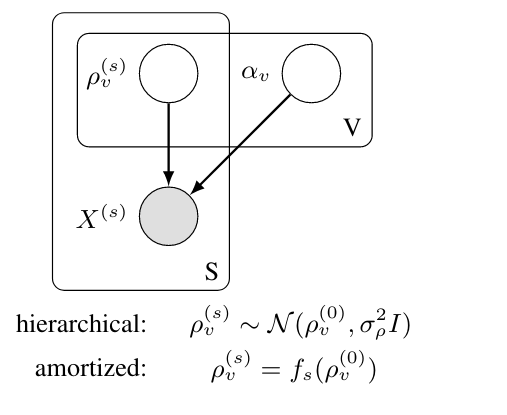

In [66]:
display.Image("images/grouped_emb_graph.png", width=500, height=400)

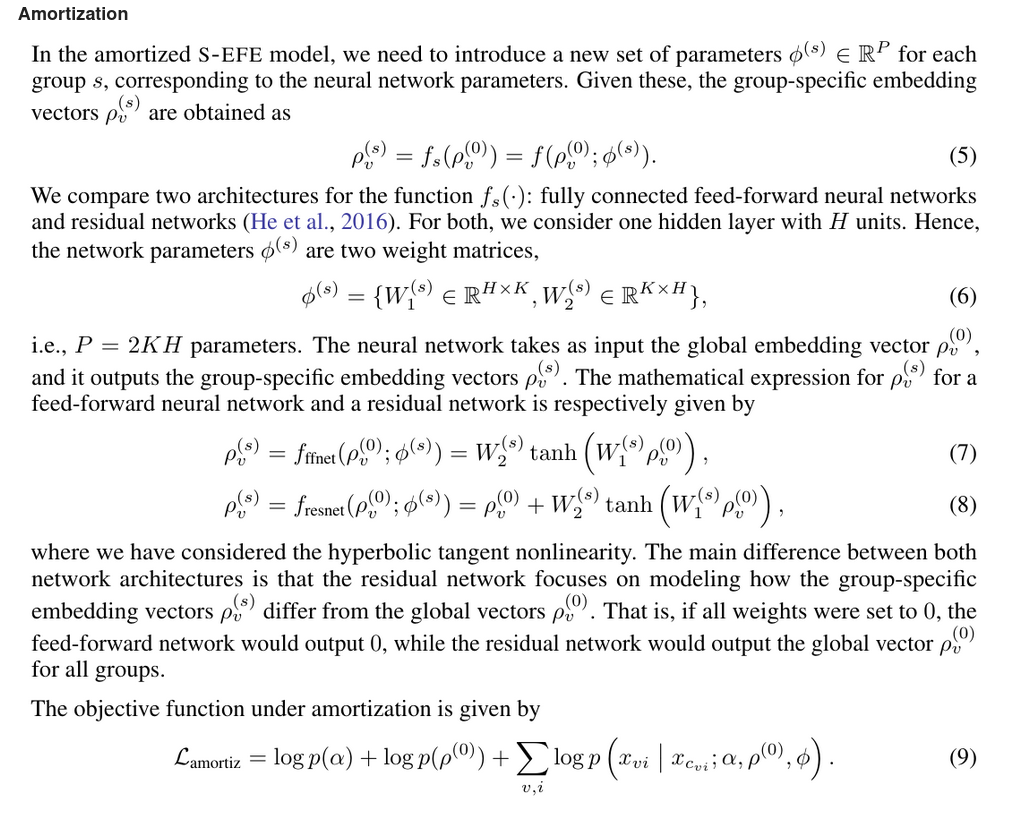

In [67]:
display.Image("images/amortization.png", width=900, height=800)

### **7.1 Data generation**

We will have to perfom a small change to the original function to generate skip-gram examples so that we can keep track of the group to which each example belongs.

In [68]:
def skipgram_examples_grouped(corpus, vocab_dict, group_ids, window=5):
    """ Function to identify center and context words in the provided corpus.
        At the moment, examples are only generated for words that are in a
        position in which sufficient context words are available (window*2).
    
    Args:
        corpus (list): containing each document of the corpus represented
          as a list of tokens
        vocab_dict (dict): mapping words to their index representation
        group_ids (list): containing the group id to which each document
          corresponds
        window (int): window*2 will be the total number of words considered
        as context; (window) words before and (window) words after the
        selected center word
        
    Returns:
        jax array of indexes representing each center word in the corpus
        jax array of jax arrays representing the indexes of context words
        jax array of integers representing the group to which the center word belongs
    """

    # lists to store the results
    centers = []
    contexts = []
    groups = []
    
    # iterate over al documents in the corpus
    for doc, group in zip(corpus, group_ids):

        center = window
        while center < (len(doc)-window):
            
            # save the group of the center word
            groups.append(group)
            
            # save the current center word
            centers.append(vocab_dict[doc[center]])
            
            # create a list to store the context of the current center
            context_words = []
            # search for context
            for i in range(0, (window*2)+1):
                if (center-window+i) != center:
                    context_words.append(vocab_dict[doc[center-window+i]])

            # append all the context words identified
            contexts.append(context_words)
            # update center
            center += 1
                   
    return jnp.array(centers), jnp.array(contexts), jnp.array(groups)

In [69]:
def gen_group2idxs(num_groups, hidden_units):
    """Function to create a dictionary that maps a group index to an array with 
       the corresponding positions for the group in the weights matrices. We need 
       this because we will create
       
    Args:
        num_groups (int): representing the total number of groups
        hidden_units (int): desired number of hidden units for NN
    
    """
    
    group2idxs = {}
    
    for group in range(num_groups):
        group2idxs[group] = jnp.array(jnp.arange(group*hidden_units, group*hidden_units + hidden_units))
    
    return group2idxs

### **7.2. Model**

In [70]:
def init_params_grouped(vocab_size, emb_size, num_groups, hidden_units, mean, std, seed):
    """ Function to generate random initial parameter matrices
    
    Args:
        vocab_size (int)
        emb_size (int)
        num_groups (int)
        hidden_units (int): number of hidden units to use in the neural network
        that transforms global embeddings into group-specfic
        mean (float): of  normal distribution
        std (float): of normal distribution
        seed (int): to initialize NumPy generator
    
    Returns:
        list with two matrices randomly generated with the specified dimensions
    """
    
     
    # initialize the generator
    generator = np.random.default_rng(seed)

    params = []    
    # use the first 2 keys to create the global word embeddings and context embeddings
    params.append(jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size))))
    params.append(jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size))))
    
    # the remaining 2 keys will generate the weights of the neural network
    params.append(jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size))))
    params.append(jnp.array(generator.normal(loc=mean, scale=std, size=(vocab_size, emb_size))))
    
    return params

In [71]:
@jit
def predict_probs_grouped(params, center_idx, contexts_idx, weigths_idxs):
    """ Execute the forward pass for a center word and it's context
    
    Args:
        params (dict): containing all the parameters of the model
        center_idx (int): index of the context word
        contexts_idx (array): containing the indexes of the contexts words
        weigths_idxs (array): containing the position of the neural network
          parameters that transform global embeddings into group-specific
    
    Returns:
        jax array in which each element corresponds to the dot product between
          the center word input embedding and one of the context words output
          embedding
    """
    
    # get the GLOBAL embedding of the center word
    global_center = jnp.take(params[0], center_idx, axis=0)
    
    # unpack the weights of the NN that transforms global embeddings into group specific    
    w1_group = jnp.take(params[2], weigths_idxs, axis=0)
    w2_group = jnp.take(params[3], weigths_idxs, axis=0)
    
    # transform the global embedding into group specific
    grouped_center = global_center + w2_group.T@jnp.tanh(w1_group@global_center)
    
    # get the context embedding for the context words
    global_contexts = jnp.take(params[1], contexts_idx, axis=0)
    
    # similarity score: dot product of group-specific center and global context embeddings
    scores = grouped_center@global_contexts.T
        
    return jax.nn.sigmoid(scores)

In [72]:
@jit
def loss_per_example_grouped(params, center_idx, contexts_idx, weigths_idxs, ns_idx, noise=0.0000001):
    """ calculate the loss for a center word and it's positive (real) and
        negative context (fake)
    
    Args:
        params (list): containing the parameters of the model
        center_idx (int): index of the context word
        contexts_idx (list): containing the indexes of the contexts words
        ns_idx (jax array): containing the indexes of the negative samples
        weigths_idxs (array): containing the position of the neural network
          parameters that transform global embeddings into group-specific
        noise (int): small quantity to avoid passing zero to the logarithm

    Returns:
        loss for a single example
    """
            
    #----------------------------
    # Loss from positive samples
    #----------------------------
    
    # get the scores for the real context
    preds_pos = predict_probs_grouped(params, center_idx, contexts_idx, weigths_idxs)
    
    # loss for the positive (real) context words
    loss_pos = jnp.sum(jnp.log(preds_pos + noise))
    
    #----------------------------
    # Loss from negative samples
    #----------------------------
    
    # get the scores for all the negative samples
    preds_neg = 1 - predict_probs_grouped(params, center_idx, ns_idx, weigths_idxs)
    
    # loss for the negative samples
    loss_neg = jnp.sum(jnp.log(preds_neg + noise))
    
    return -(loss_pos + loss_neg)

In [73]:
# create a vectorized version of the loss using the vmap function from JAX
# the option "in_axes" indicates over which parameters to iterate
batched_loss_grouped = jit(vmap(loss_per_example_grouped, in_axes=(None, 0, 0, 0, 0, None)))

In [74]:
@jit
def complete_loss_grouped(params, all_center_idx, all_contexts_idx, all_ns_idx, all_weigths_idxs, noise):
    """ function to calculate the loss for a batch of data by adding the
        individual losses for each example
    
    Args:
        params (list): containing the parameters of the model
        all_center_idx (list): containing all indexes of center words
        all_contexts_idx (list): containing the indexes for the context words
        all_ns_idx (list): containing all negative samples
        all_weights_idxs (list):

    Returns:
        average loss for all examples (float)
    """
        
    # get all losses from the examples
    losses = batched_loss_grouped(params, all_center_idx, all_contexts_idx, all_ns_idx, all_weigths_idxs, noise)
    
    return jnp.sum(losses)/all_center_idx.shape[0]

In [75]:
# use JAX to create a vesion of the loss function that can handle gradients
# the option "argnums" indicates where the parameters of the model are.
# finally use JIT to speed up computations... All JAX magic in one place

grad_loss_grouped = jit(value_and_grad(complete_loss_grouped, argnums=0))

In [76]:
@jit
def update_grouped(params, step, all_center_idx, all_contexts_idx, all_ns_idx, all_weigths_idxs, noise, opt_state):
    """ compute the gradient for a batch of data and update parameters
    """
    
    # calculate the gradients and the value of the loss function
    loss_value, grads = grad_loss_grouped(params, all_center_idx, all_contexts_idx, all_ns_idx, all_weigths_idxs, noise)
    
    # update the parameters with a gradient descent algorithm
    opt_state = opt_update(step, grads, opt_state)

    return loss_value, get_params(opt_state), opt_state 

### **7.3. Training**

We will use the same two periods as in the previous example but, instead of splitting the data, we will just create a group identifier.

In [77]:
df_dec["group"] = 0
df_dec.head(5)

<ipython-input-77-f8343b2313fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec["group"] = 0


,ir_date,paragraph,section,sub_section,sub_sub_section,sub_sub_sub_section,sub_sub_sub_sub_section,year,yearmonth,group
8580,200805,"In the United Kingdom, output growth moderated...",0.0,NaN,NaN,NaN,NaN,2008-05-01,200805,0
8581,200805,CPI inflation was 2.5% in March. Energy and i...,0.0,NaN,NaN,NaN,NaN,2008-05-01,200805,0
8582,200805,Financial markets remained under stress. The ...,0.0,Finacial markets,NaN,NaN,NaN,2008-05-01,200805,0
8583,200805,The MPC cut Bank Rate to 5% at its April meeti...,0.0,Finacial markets,NaN,NaN,NaN,2008-05-01,200805,0
8584,200805,Domestic demand growth moderated in 2007 Q4 on...,0.0,Domestic demand,NaN,NaN,NaN,2008-05-01,200805,0


In [78]:
df_inc["group"] = 1
df_inc.head(5)

<ipython-input-78-63df64c45f52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inc["group"] = 1


,ir_date,paragraph,section,sub_section,sub_sub_section,sub_sub_sub_section,sub_sub_sub_sub_section,year,yearmonth,group
6923,200605,"Over the past six months, output growth has re...",0.0,NaN,NaN,NaN,NaN,2006-05-01,200605,1
6924,200605,"With unemployment continuing to rise, pay pres...",0.0,NaN,NaN,NaN,NaN,2006-05-01,200605,1
6925,200605,Consumers’ expenditure recovered through 2005 ...,0.0,Domestic demand,NaN,NaN,NaN,2006-05-01,200605,1
6926,200605,Recent outturns for government spending have b...,0.0,Domestic demand,NaN,NaN,NaN,2006-05-01,200605,1
6927,200605,Official estimates suggest that business inves...,0.0,Domestic demand,NaN,NaN,NaN,2006-05-01,200605,1


In [79]:
# merge the two datasets into a single one
df_train = pd.concat([df_dec, df_inc])
df_train.head(10)

,ir_date,paragraph,section,sub_section,sub_sub_section,sub_sub_sub_section,sub_sub_sub_sub_section,year,yearmonth,group
8580,200805,"In the United Kingdom, output growth moderated...",0.0,NaN,NaN,NaN,NaN,2008-05-01,200805,0
8581,200805,CPI inflation was 2.5% in March. Energy and i...,0.0,NaN,NaN,NaN,NaN,2008-05-01,200805,0
8582,200805,Financial markets remained under stress. The ...,0.0,Finacial markets,NaN,NaN,NaN,2008-05-01,200805,0
8583,200805,The MPC cut Bank Rate to 5% at its April meeti...,0.0,Finacial markets,NaN,NaN,NaN,2008-05-01,200805,0
8584,200805,Domestic demand growth moderated in 2007 Q4 on...,0.0,Domestic demand,NaN,NaN,NaN,2008-05-01,200805,0
8585,200805,Business investment growth eased a little in t...,0.0,Domestic demand,NaN,NaN,NaN,2008-05-01,200805,0
8586,200805,Government spending made a moderate contributi...,0.0,Domestic demand,NaN,NaN,NaN,2008-05-01,200805,0
8587,200805,International economic prospects have continue...,0.0,Overseas trade,NaN,NaN,NaN,2008-05-01,200805,0
8588,200805,Weaker growth in overseas markets will bear do...,0.0,Overseas trade,NaN,NaN,NaN,2008-05-01,200805,0
8589,200805,"According to the ONS’s preliminary estimate, G...",0.0,The outlook for GDP growth,NaN,NaN,NaN,2008-05-01,200805,0


In [80]:
# clean the environment
del df_dec
del df_inc
del centers_dec
del centers_inc
del contexts_dec
del contexts_inc
del neg_samples_dec
del neg_samples_inc

In [82]:
# preprocess reports
prep, word2idx, idx2word, vocab = apply_preprocessing(df_train, replace_dict, punctuation)
print(f"Number of words in the vocabulary: {len(vocab)}")

Number of words in the vocabulary: 1362


In [83]:
# generate skip-gram examples
window_size = 4
centers, contexts, groups = skipgram_examples_grouped(prep.tokens, word2idx, df_train["group"], window_size)
print(centers.shape, contexts.shape, groups.shape)

(114062,) (114062, 8) (114062,)


In [84]:
# explore a random example
i = np.random.randint(0, centers.shape[0])
print(i)
print(centers[i])
print(contexts[i])
print(groups[i])

101851
437
[ 897 1307  844 1210 1351  274  431  685]
1


In [85]:
# generate negative samples
num_ns = 10
neg_samples = gen_neg_samples(centers, contexts, list(idx2word.keys()), num_ns)
print(neg_samples.shape)

(114062, 80)


In [86]:
# generate a mapping between the group ID and the corresponding weigths of the NN
num_groups = 2
hidden_units = 10
group2idxs = gen_group2idxs(num_groups, hidden_units)
weigths_idxs = jnp.array([group2idxs[g] for g in groups])
weigths_idxs.shape

(114062, 10)

Number of batches to process 2735 in 30 epochs
Epoch 0 in 17.76 sec
Loss value: 102734.7421875
Epoch 1 in 14.99 sec
Loss value: 4829.5673828125
Epoch 2 in 18.71 sec
Loss value: 2533.65478515625
Epoch 3 in 18.92 sec
Loss value: 2350.488037109375
Epoch 4 in 17.40 sec
Loss value: 2301.54052734375
Epoch 5 in 20.36 sec
Loss value: 2233.881103515625
Epoch 6 in 13.22 sec
Loss value: 2007.896484375
Epoch 7 in 17.79 sec
Loss value: 1858.29248046875
Epoch 8 in 14.17 sec
Loss value: 1791.5111083984375
Epoch 9 in 14.20 sec
Loss value: 1747.7718505859375
Epoch 10 in 13.97 sec
Loss value: 1714.0538330078125
Epoch 11 in 14.04 sec
Loss value: 1688.83349609375
Epoch 12 in 20.48 sec
Loss value: 1677.481201171875
Epoch 13 in 17.12 sec
Loss value: 1668.6644287109375
Epoch 14 in 17.98 sec
Loss value: 1659.8524169921875
Epoch 15 in 18.15 sec
Loss value: 1652.60107421875
Epoch 16 in 18.89 sec
Loss value: 1648.803466796875
Epoch 17 in 16.73 sec
Loss value: 1643.477783203125
Epoch 18 in 16.36 sec
Loss value: 1

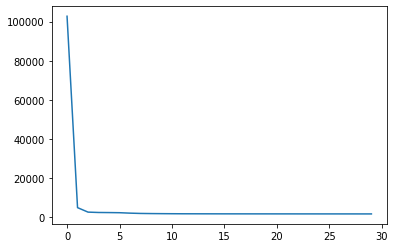

In [151]:
# create some lists to log data
loss_epoch = []

# define vocabulary and embedding size
vocab_size = len(vocab)
emb_size = 100

# training parameters
noise = 0.00000001
step_size = 0.001
num_epochs = 30
batch_size = 64

# randomly initialize the weights matrices
params_seed = 92
params_mean = 0
params_std = 0.5

params = init_params_grouped(vocab_size, emb_size, num_groups, hidden_units, params_mean, params_std, params_seed)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

# keep track of how many times we are updating the parameters
num_updates = 0

num_batches = math.floor(centers.shape[0]/batch_size)
print(f"Number of batches to process {num_batches} in {num_epochs} epochs")

# train through the epochs
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # IMPORTANT: SHUFFLE EXAMPLES IN EVERY EPOCH!    
    indexes = jnp.array(list(range(0, centers.shape[0])))
    shuffled_idx = jax.random.permutation(Key(epoch), indexes)
    centers = jnp.take(centers, shuffled_idx, axis=0)
    contexts = jnp.take(contexts, shuffled_idx, axis=0)
    neg_samples = jnp.take(neg_samples, shuffled_idx, axis=0)
    weigths_idxs = jnp.take(weigths_idxs, shuffled_idx, axis=0)
    
    # split data into batches
    init_index = 0
    end_index = batch_size
    
    loss_epoch_list = []
    for batch in range(num_batches+1):
        
        # get the data from the current batch
        batch_idx = jnp.array(range(init_index, end_index))
        batch_centers = jnp.take(centers, batch_idx, axis=0)
        batch_contexts = jnp.take(contexts, batch_idx, axis=0)
        batch_ns = jnp.take(neg_samples, batch_idx, axis=0)
        batch_weigths = jnp.take(weigths_idxs, batch_idx, axis=0)
        
        # calculate gradients and update parameters for each batch
        loss_batch, params, opt_state = update_grouped(params, num_updates, batch_centers, 
                                                       batch_contexts, batch_ns, batch_weigths,
                                                       noise, opt_state)
        loss_epoch_list.append(loss_batch)
        num_updates += 1
        
        # update indexes
        init_index = end_index
        # if we are in the last batch...
        if batch == num_batches-1:
            end_index = centers.shape[0]
        else:
            end_index += batch_size
                
    epoch_time = time.time() - start_time
    loss_epoch.append(sum(loss_epoch_list))
    
    if epoch%10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Loss value: {}".format(sum(loss_epoch_list)))
    
plt.plot(list(range(num_epochs)), loss_epoch)
plt.show()

### **7.4. Exploration**

TODO: Show words with higher differences between their embeddings in the two periods

In [152]:
# calculate the group-specific embeddings
embeddings_dec = []
embeddings_inc = []

# get the positions of the weights corresponding to each group
weigths_idxs_dec = group2idxs[0]
weigths_idxs_inc = group2idxs[1]

w1_dec = jnp.take(params[2], weigths_idxs_dec, axis=0)
w1_inc = jnp.take(params[2], weigths_idxs_inc, axis=0)

w2_dec = jnp.take(params[3], weigths_idxs_dec, axis=0)
w2_inc = jnp.take(params[3], weigths_idxs_inc, axis=0)


for global_emb in params[0]:
    embeddings_dec.append(global_emb + w2_dec.T@jnp.tanh(w1_dec@global_emb))
    embeddings_inc.append(global_emb + w2_inc.T@jnp.tanh(w1_inc@global_emb))

In [153]:
embeddings_dec = jnp.array(embeddings_dec)
embeddings_inc = jnp.array(embeddings_inc)
print(embeddings_dec.shape, embeddings_inc.shape)

(1694, 100) (1694, 100)


In [154]:
# create an indexer for our estimated word embeddings
indexer_dec = build_indexer(embeddings_dec, 10000)
indexer_inc = build_indexer(embeddings_inc, 10000)
indexer_global = build_indexer(params[0], 10000)

In [155]:
word = "economy"
N = 20
print(f"{N} nearest neighbors of {word} in the global embeddings:\n")
print(find_nn(word, word2idx, idx2word, indexer_global, N))
print("------------------------------------------------------------\n")
print(f"{N} nearest neighbors of {word} in the DESCENDING group:\n")
print(find_nn(word, word2idx, idx2word, indexer_dec, N))
print("------------------------------------------------------------\n")
print(f"{N} nearest neighbors of {word} in the INCREASING gorup:\n")
print(find_nn(word, word2idx, idx2word, indexer_inc, N))

20 nearest neighbors of economy in the global embeddings:

['back', 'direct', 'affected', 'line', 'place', 'mid-', 'full', 'need', 'economies', 'better', 'run', 'reductions', 'respond', 'feed', 'package', 'holdings', 'prompt', 'bearing', 'lie', 'push']
------------------------------------------------------------

20 nearest neighbors of economy in the DESCENDING group:

['line', 'back', 'moves', 'budget', 'announced', 'intensified', 'age', 'eligible', 'take', 'putting', 'numbers', 'elevated', 'unemployment', 'wages', 'difficulty', 'unemployed', 'surplus', 'broad-based', 'strongest', 'complete']
------------------------------------------------------------

20 nearest neighbors of economy in the INCREASING gorup:

['transmission', 'now', 'adverse', 'vat', 'covered', 'prospects', 'asset', 'benefits', 'remaining', 'figures', 'restructure', 'chancellor', 'months', 'results', 'creation', 'page', 'come', 'precautionary', 'business', 'data']


In [156]:
pairs = [("economy", "risk"), ("inflation", "risk"), ("economy", "increase"), ("economy", "slowdown")]

for pair in pairs:
    cos_dec = 1 - spatial.distance.cosine(embeddings_dec[word2idx[pair[0]]], embeddings_dec[word2idx[pair[1]]])
    print(f"Cosine similarity between {pair[0]} and {pair[1]} in the DECREASING group: {np.round(cos_dec, 2)}\n")
    cos_inc = 1 - spatial.distance.cosine(embeddings_inc[word2idx[pair[0]]], embeddings_inc[word2idx[pair[1]]])
    print(f"Cosine similarity between {pair[0]} and {pair[1]} in the INCREASING group: {np.round(cos_inc, 2)}\n")
    print("--------------------------------------------------------")

Cosine similarity between economy and risk in the DECREASING group: 0.78

Cosine similarity between economy and risk in the INCREASING group: 0.53

--------------------------------------------------------
Cosine similarity between inflation and risk in the DECREASING group: 0.44

Cosine similarity between inflation and risk in the INCREASING group: 0.74

--------------------------------------------------------
Cosine similarity between economy and increase in the DECREASING group: 0.79

Cosine similarity between economy and increase in the INCREASING group: 0.78

--------------------------------------------------------
Cosine similarity between economy and slowdown in the DECREASING group: 0.69

Cosine similarity between economy and slowdown in the INCREASING group: 0.88

--------------------------------------------------------
